In [1]:
import numpy as np
import pandas as pd
import os
import random
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
@dataclass
class GLOBAL:
    INPUT_PATH = '../input/100-bird-species/'
    IMAGE_SIZE = (150, 150)
    INPUT_SHAPE = (150, 150, 3)
    BATCH_SIZE = 64

In [3]:
birds_df = pd.read_csv('../input/100-bird-species/birds.csv')
birds_df['filepaths'] = GLOBAL.INPUT_PATH + birds_df['filepaths']
birds_df

,class index,filepaths,labels,data set
0,0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train
1,0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train
2,0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train
3,0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train
4,0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train
...,...,...,...,...
62383,399,../input/100-bird-species/valid/YELLOW HEADED ...,YELLOW HEADED BLACKBIRD,valid
62384,399,../input/100-bird-species/valid/YELLOW HEADED ...,YELLOW HEADED BLACKBIRD,valid
62385,399,../input/100-bird-species/valid/YELLOW HEADED ...,YELLOW HEADED BLACKBIRD,valid
62386,399,../input/100-bird-species/valid/YELLOW HEADED ...,YELLOW HEADED BLACKBIRD,valid


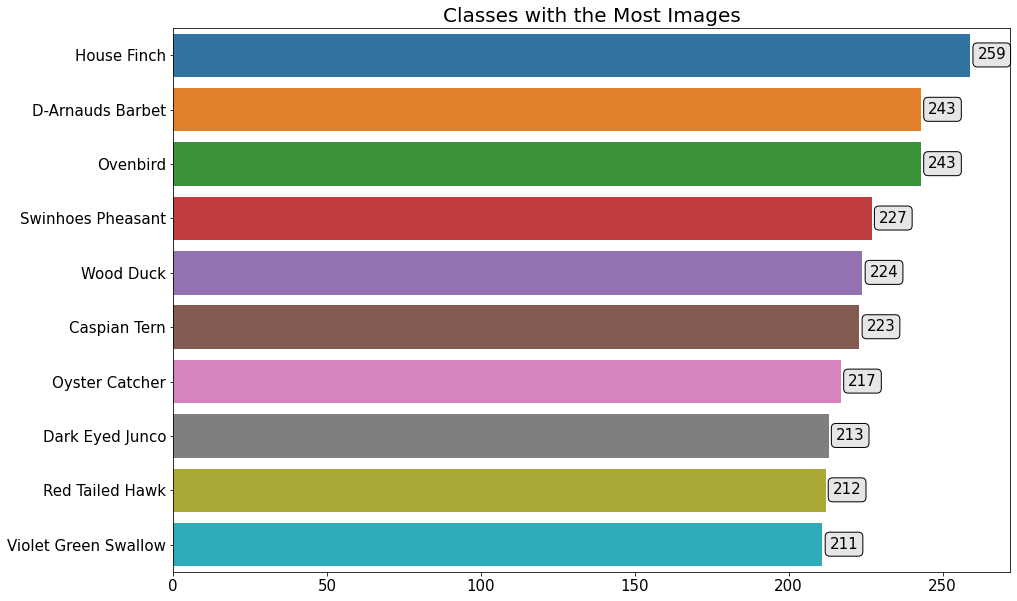

In [4]:
keys = birds_df['labels'].value_counts().index.tolist()[0:10]
keys = [bird.title() for bird in keys]
values = birds_df['labels'].value_counts().to_list()[0:10]
plt.figure(figsize = (15, 10))
ax = sns.barplot(x = values, y = keys)
plt.title('Classes with the Most Images', fontsize = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)

bbox_args = dict(boxstyle = 'round', fc = '0.9')
for p in ax.patches:
    width = p.get_width()
    plt.text(7 + p.get_width(), p.get_y() + 0.49 * p.get_height(),
             '{:.0f}'.format(width),
             ha='center', va='center',
             color = 'black',
             bbox = bbox_args,
             fontsize = 15)

plt.show()

In [5]:
train_df = (birds_df.groupby(birds_df['data set'])).get_group('train')
valid_df = (birds_df.groupby(birds_df['data set'])).get_group('valid')
test_df = (birds_df.groupby(birds_df['data set'])).get_group('test')
train_df

,class index,filepaths,labels,data set
0,0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train
1,0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train
2,0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train
3,0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train
4,0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train
...,...,...,...,...
58383,399,../input/100-bird-species/train/YELLOW HEADED ...,YELLOW HEADED BLACKBIRD,train
58384,399,../input/100-bird-species/train/YELLOW HEADED ...,YELLOW HEADED BLACKBIRD,train
58385,399,../input/100-bird-species/train/YELLOW HEADED ...,YELLOW HEADED BLACKBIRD,train
58386,399,../input/100-bird-species/train/YELLOW HEADED ...,YELLOW HEADED BLACKBIRD,train


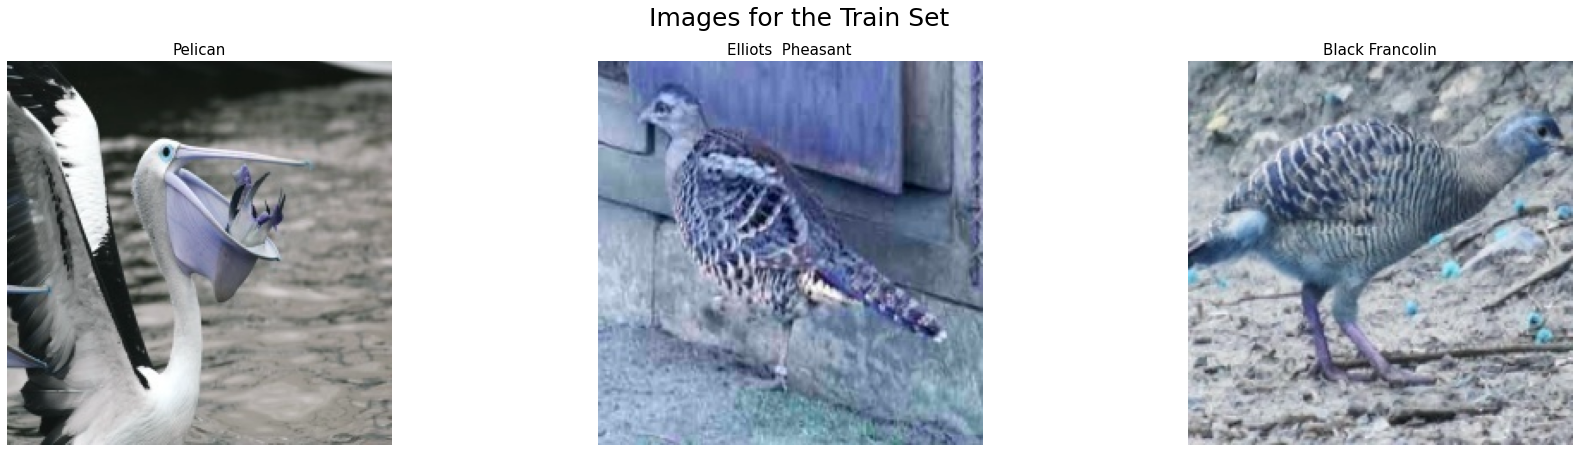

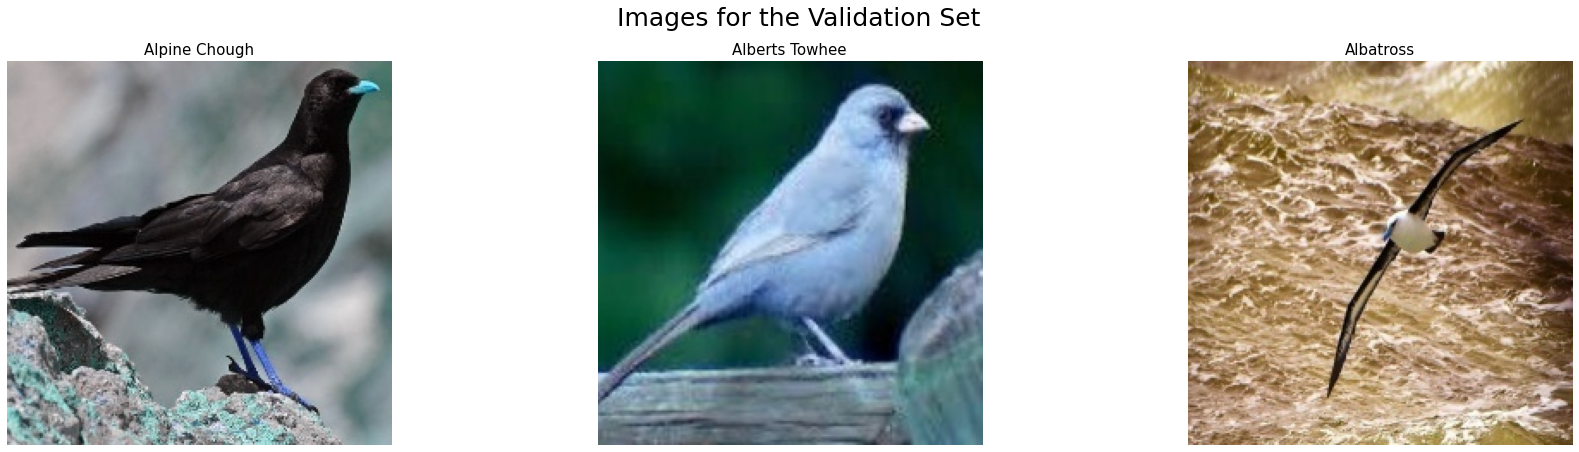

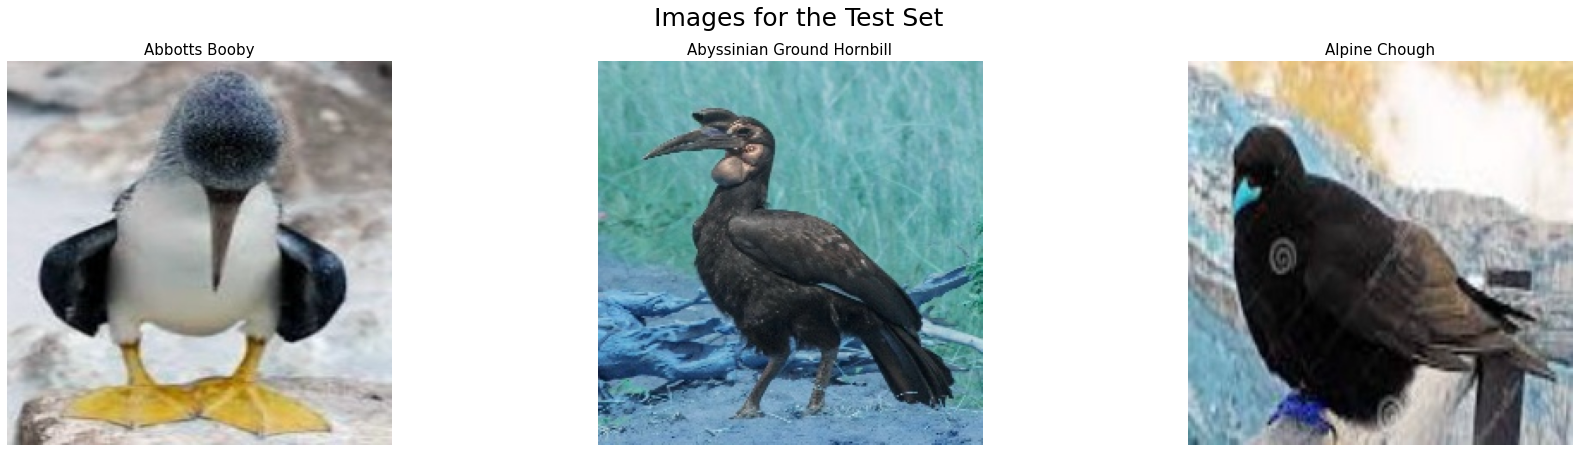

In [6]:
def plot_random_images(dataframe, type_of_set):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (25, 8))
    
    plt.suptitle('Images for the ' + type_of_set + ' Set', fontsize = 25)
    
    random_list = []
    
    for i in range(0, 3):
        random_number = random.randint(0, len(dataframe))
        random_list.append(random_number)
        
    for i in range(3):
        axes[i].imshow(cv2.imread(train_df.iloc[random_list[i], 1]))
        axes[i].set_title(train_df.iloc[random_list[i], 2].title(), fontsize = 15)
        axes[i].axis('off')
        
    plt.tight_layout(rect = [0, 0.2, 0.99, 0.975])
    plt.show()
    print('\n\n')
    
plot_random_images(train_df, 'Train')
plot_random_images(valid_df, 'Validation')
plot_random_images(test_df, 'Test')

In [7]:
train_datagen = ImageDataGenerator(rescale = 1 / 255.0,
                                   rotation_range = 15,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

valid_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_datagen = ImageDataGenerator(rescale = 1 / 255.0)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                    x_col = 'filepaths',
                                                    y_col = 'labels',
                                                    target_size = GLOBAL.IMAGE_SIZE,
                                                    batch_size = GLOBAL.BATCH_SIZE,
                                                    class_mode = 'categorical')

valid_generator = valid_datagen.flow_from_dataframe(dataframe = valid_df,
                                                    x_col = 'filepaths',
                                                    y_col = 'labels',
                                                    target_size = GLOBAL.IMAGE_SIZE,
                                                    batch_size = GLOBAL.BATCH_SIZE,
                                                    class_mode = 'categorical')

test_generator = test_datagen.flow_from_dataframe(dataframe = test_df,
                                                  x_col = 'filepaths',
                                                  y_col = 'labels',
                                                  target_size = GLOBAL.IMAGE_SIZE,
                                                  batch_size = GLOBAL.BATCH_SIZE,
                                                  class_mode = 'categorical')

Found 58388 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.
Found 2000 validated image filenames belonging to 400 classes.


In [ ]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('../working/labels.txt', 'w') as f:
    f.write(labels)

In [8]:
mobielnet_v2_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top = False,
                                                                    weights = 'imagenet',
                                                                    input_shape = GLOBAL.INPUT_SHAPE)
mobielnet_v2_model.trainable = False

total_params = mobielnet_v2_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in mobielnet_v2_model.trainable_weights])

print(f"There are {total_params:,} total parameters in the pre-trained MobileNetV2 model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

2022-08-25 08:12:07.388145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 08:12:07.524649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 08:12:07.525522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 08:12:07.527309: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step
There are 2,257,984 total parameters in the pre-trained MobileNetV2 model.
There are 0 trainable parameters in this model.


In [9]:
mobielnet_v2_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

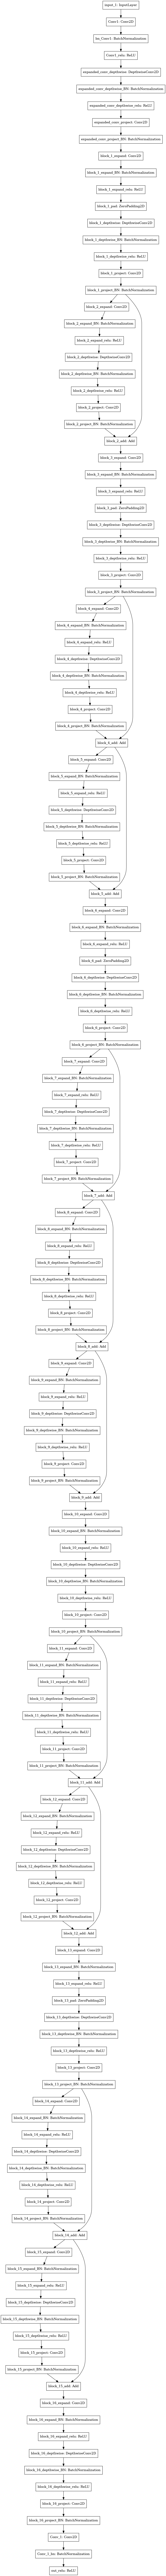

In [10]:
plot_model(mobielnet_v2_model)

In [11]:
mobilenet_tl_model = Sequential([
    mobielnet_v2_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(units = 1024, activation = 'relu'),
    Dense(units = 512, activation = 'relu'),
    BatchNormalization(),
    Dense(units = 400, activation = 'softmax')
])

mobilenet_tl_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = keras.optimizers.Adam(),
    metrics = ['acc']
)

In [12]:
mobilenet_tl_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 400)               2

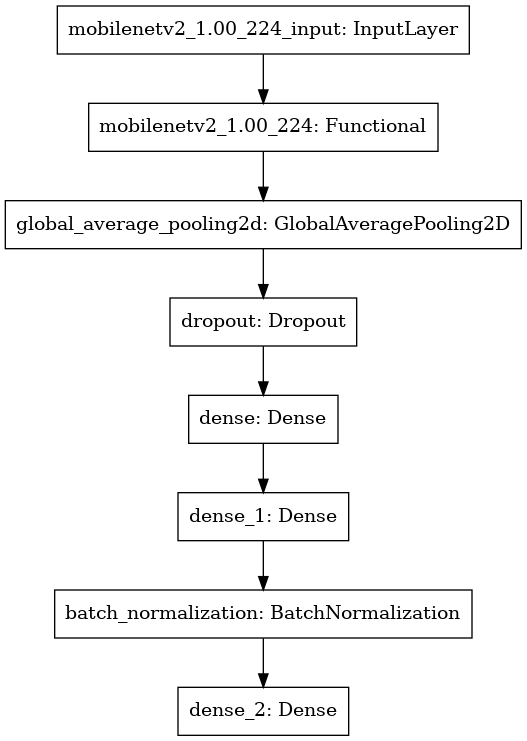

In [13]:
plot_model(mobilenet_tl_model)

In [14]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
early_stop = EarlyStopping(monitor = 'val_acc', patience = 3)

In [15]:
classifier = mobilenet_tl_model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 20,
    verbose = 1,
    callbacks = [reduce_lr, early_stop]
)

2022-08-25 08:12:15.752570: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-08-25 08:12:19.837588: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


913/913 [==============================] - 637s 688ms/step - loss: 2.1933 - acc: 0.5021 - val_loss: 1.0405 - val_acc: 0.7145
Epoch 2/20
913/913 [==============================] - 396s 434ms/step - loss: 1.3764 - acc: 0.6453 - val_loss: 0.8644 - val_acc: 0.7680
Epoch 3/20
913/913 [==============================] - 394s 432ms/step - loss: 1.2325 - acc: 0.6770 - val_loss: 0.7405 - val_acc: 0.7905
Epoch 4/20
913/913 [==============================] - 391s 428ms/step - loss: 1.1328 - acc: 0.7009 - val_loss: 0.6499 - val_acc: 0.8095
Epoch 5/20
913/913 [==============================] - 398s 436ms/step - loss: 1.0659 - acc: 0.7135 - val_loss: 0.6706 - val_acc: 0.8010
Epoch 6/20
913/913 [==============================] - 389s 426ms/step - loss: 1.0012 - acc: 0.7284 - val_loss: 0.5780 - val_acc: 0.8260
Epoch 7/20
913/913 [==============================] - 391s 428ms/step - loss: 0.9478 - acc: 0.7417 - val_loss: 0.5711 - val_acc: 0.8350
Epoch 8/20
913/913 [==============================] - 389s 

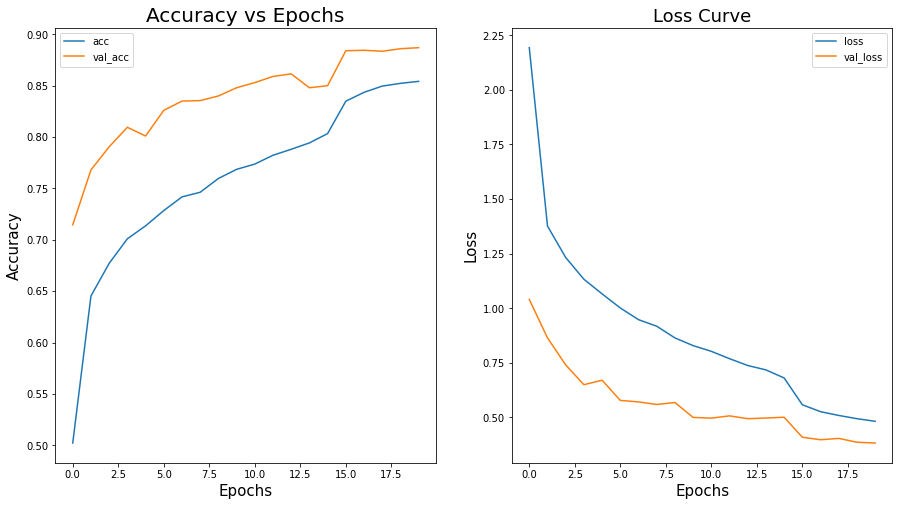

In [16]:
def model_performance_graphs(classifier):
    
    fig, axes = plt.subplots(1, 2, figsize = (15, 8))

    axes[0].plot(classifier.epoch, classifier.history['acc'], label = 'acc')
    axes[0].plot(classifier.epoch, classifier.history['val_acc'], label = 'val_acc')
    axes[0].set_title('Accuracy vs Epochs', fontsize = 20)
    axes[0].set_xlabel('Epochs', fontsize = 15)
    axes[0].set_ylabel('Accuracy', fontsize = 15)
    axes[0].legend()

    axes[1].plot(classifier.epoch, classifier.history['loss'], label = 'loss')
    axes[1].plot(classifier.epoch, classifier.history['val_loss'], label="val_loss")
    axes[1].set_title("Loss Curve",fontsize=18)
    axes[1].set_xlabel("Epochs",fontsize=15)
    axes[1].set_ylabel("Loss",fontsize=15)
    axes[1].legend()

    plt.show()
    
model_performance_graphs(classifier)

In [17]:
mobilenet_tl_model.evaluate(test_generator)

32/32 [==============================] - 14s 431ms/step - loss: 0.2916 - acc: 0.9120


[0.2915911376476288, 0.9120000004768372]

In [18]:
mobilenet_tl_model.save('../working/bird_classifier.h5')

In [19]:
model = tf.keras.models.load_model('../working/bird_classifier.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('../working/bird_classifier.h5.tflite', 'wb').write(tflite_model)

2022-08-25 10:29:38.177830: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-25 10:29:54.161165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 10:29:54.161599: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-08-25 10:29:54.161740: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-08-25 10:29:54.162239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 10:29:54.162728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had ne

17036592

In [20]:
predictions = model.predict_generator(test_generator)
print(len(predictions[0]))
final_labels = np.argmax(predictions, axis = 1)
print(final_labels)
df = pd.DataFrame(final_labels)
df.value_counts()

400
[ 58  68 196 ... 262 189 331]


101    10
119     9
258     8
373     8
375     8
       ..
273     2
135     2
140     2
144     2
214     2
Length: 400, dtype: int64

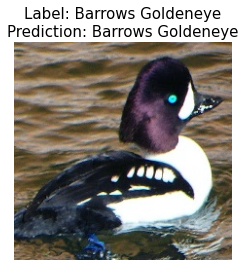

In [21]:
random_number = random.randint(0, len(test_df))
img = cv2.imread(test_df.iloc[random_number, 1])

rescaled_image = img / 255.0
resized_image = cv2.resize(rescaled_image, (150, 150))
model_input_image = np.expand_dims(resized_image, axis = 0)
prediction = model.predict(model_input_image)
final_prediction = np.argmax(prediction, axis = 1)

plt.imshow(img)
plt.title('Label: ' + test_df.iloc[random_number, 2].title() + '\nPrediction: ' + ((birds_df['labels'].unique())[int(final_prediction)]).title(), fontsize = 15)
plt.axis('off')
plt.show()

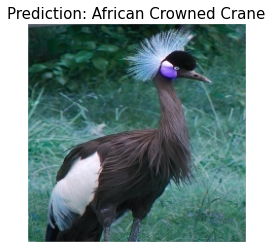

In [22]:
img = cv2.imread('../input/100-bird-species/images to test/3.jpg')
rescaled_image = img / 255.0
resized_image = cv2.resize(rescaled_image, (150, 150))
model_input_image = np.expand_dims(resized_image, axis = 0)
prediction = model.predict(model_input_image)
final_prediction = np.argmax(prediction, axis = 1)
plt.imshow(img)
plt.title('Prediction: ' + ((birds_df['labels'].unique())[int(final_prediction)]).title(), fontsize = 15)
plt.axis('off')
plt.show()